# Tutorial on Soft Stability

Welcome to our tutorial! We'll show you some core soft stability functionalities for vision-based examples.

In [1]:
import math
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

torch.manual_seed(1234)

Because we're focusing on vision, let's load up an image.

Shape torch.Size([3, 224, 224])


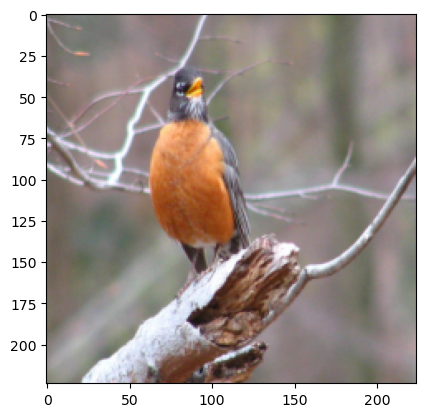

In [2]:
image_raw = PIL.Image.open("imagenet-sample-images/n01558993_robin.JPEG")
image_pt = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224))
])(image_raw)

print("Shape", image_pt.shape)
plt.clf(); plt.imshow(image_pt.numpy().transpose(1,2,0))

What a cute little `ROBIN`! Now let's see what Professor ResNet thinks about you.

In [3]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1).eval()
print(model(image_pt.view(1,3,224,224)).argmax(dim=-1))

tensor([15])


The classification is correct, as described by the list here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

Now let's talk features.
Our images are of shape `(3,224,224)`, which corresponds to an RGB channel with height-224 and width-224 pixels.
We split this into 32-by-32 patches, which makes a 7-by-7 grid because 224/32 = 7.
This means there are a total of 49 = 7 x 7 features (more accurately: feature groups).

Consequently, our explanations take the form $\alpha \in \{0,1\}^{49}$. Let's see an example.

In [4]:
def mask_image(image, selected_features):
    """
    Args:
        image (torch.FloatTensor): of shape (3,224,224).
        selected_features (torch.Tensor): a 0/1-valued tensor of shape (7,7).

    Returns:
        torch.FloatTensor: the alpha-masked image.
    """
    big_mask = torch.nn.functional.interpolate(selected_features.float().view(1,1,7,7), size=(224,224)) # (1,1,224,224)
    masked_image = image.view(1,3,224,224) * big_mask # (1,3,224,224)
    return masked_image.view(3,224,224)

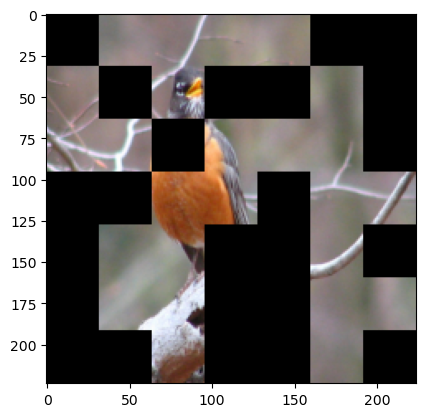

In [5]:
# alpha = your_favorite_feature_selection_method(resnet18, image_pt)
alpha = torch.rand(49) < 0.50 # A random selection will do for now
masked_image = mask_image(image_pt, alpha)
plt.clf(); plt.imshow(masked_image.numpy().transpose(1,2,0))

In [6]:
original_pred = model(image_pt.view(1,3,224,224)).argmax(dim=-1)
masked_pred = model(masked_image.view(1,3,224,224)).argmax(dim=-1)
print(original_pred, masked_pred)

tensor([15]) tensor([700])


Class ID 700 is ... `PAPER TOWEL`?
That's interesting.
Well, we can use soft stability to measure the confidence of this (incorrect) prediction.


To check confidence, we can randomly sample from $\leq r$-sized additive perturbations of $\alpha$, which we call:
$$
\Delta_r (\alpha) = \{\alpha' \in \{0,1\}^n : \alpha' \geq \alpha, \lVert \alpha' - \alpha \lVert_0 \leq r\}.
$$


A computational challenge of uniform sampling from $\Delta_r (\alpha)$ is that each $j$-sized perturbation for $j = 0, 1, \ldots, r$ is weighted by $\frac{\binom{m}{j}}{\sum_{i = 0}^{r} \binom{m}{i}}$, where $m = n - \lVert \alpha \rVert_0$ is the number of features not selected by $\alpha$.
This is not good, because multiplying and dividing by things of form $\binom{m}{i}$ (which can be very large) easily leads to numerical instability.
We instead have to sample from the log-space using the Gumbel softmax trick.

In [7]:
def sample_alpha_pertbs(alpha: torch.LongTensor, radius: int, num_samples: int):
    """
    Sample uniformly from:
        Delta_r = {alpha' : alpha' >= alpha, |alpha' - alpha| <= r}

    Args:
        alpha (torch.LongTensor): The 0/1-valued tensor of shape (n,).
        radius (int): The radius within which we sample.
        num_samples (int): The number of perturbed samples to generate.

    Returns:
        torch.LongTensor: Sampled perturbations of shape (num_samples, n).
    """
    original_shape = alpha.shape
    alpha = alpha.view(-1)

    samples = alpha.view(1, -1).repeat(num_samples, 1)

    # Find indices where alpha is 0 (these can potentially be flipped to 1)
    zero_indices = torch.nonzero(alpha == 0, as_tuple=False).squeeze()
    num_zeros = zero_indices.numel()
    if radius > num_zeros:
        raise ValueError(f"Radius {radius} > num zeros {num_zeros}")

    # Compute log-binomial coefficients in log-space, because we have massive blow-up otherwise.
    log_flip_probs = torch.tensor(
        [
            math.lgamma(num_zeros + 1) - math.lgamma(i + 1) - math.lgamma(num_zeros - i + 1)
            for i in range(radius + 1)
        ],
        dtype = torch.float32,
        device = alpha.device
    )

    # Convert log-probs to sampling-friendly format via Gumbel-max trick
    gumbel_noise = -torch.log(-torch.log(torch.rand(num_samples, radius + 1, device=alpha.device)))
    log_probs_with_noise = log_flip_probs.view(1, -1) + gumbel_noise
    num_flips = torch.argmax(log_probs_with_noise, dim=-1)

    # Select random indices to flip in each sample
    for i, flips in enumerate(num_flips):
        flip_inds = torch.randperm(num_zeros)[:flips]
        samples[i, zero_indices[flip_inds]] = 1 # Flip selected indices from 0 to 1

    return samples.view(num_samples, *original_shape).long()

Once we can uniformly sample from $\Delta_r (\alpha)$, we can then estimate the stability rate as follows.

In [8]:
@torch.no_grad()
def estimate_stability_rate(
    f,
    x: torch.FloatTensor,
    alpha: torch.LongTensor,
    radius: int,
    epsilon: float = 0.05,
    delta: float = 0.05,
    batch_size: int = 16,
):
    """
    Measure the soft stability rate for a classifier of form y = f(x, alpha), where:
        soft_stability_rate = Pr_{alpha' ~ Delta_r} [f(x, alpha') == f(x, alpha)]

    Args:
        f: Any function (ideally nn.Module) that takes as input x, alpha.
        x: The input to f of some shape. NOT batched.
        alpha: The 0/1 attribution of some shape. NOT batched.
        radius: The radius to which we give the guarantee.
        epsilon: The error tolerance.
        delta: The admissible failure probability
        batch_size: The batch size in case we run out-of-memory.

    Returns:
        soft_stability_rate: A value between 0 and 1.
    """
    C, H, W = x.shape
    num_samples = int(math.log(2/delta) / (2 * (epsilon**2))) + 1
    y = f(mask_image(x, alpha).unsqueeze(0)) # Reference prediction
    all_y_pertbs = []

    for alpha_pertbs in torch.split(sample_alpha_pertbs(alpha, radius, num_samples), batch_size):
        x_pertbs = torch.stack([mask_image(x, a) for a in alpha_pertbs])
        y_pertbs = f(x_pertbs)
        all_y_pertbs.append(y_pertbs)

    all_y_pertbs = torch.cat(all_y_pertbs, dim=0)
    stab_rate = (y.argmax(dim=-1) == all_y_pertbs.argmax(dim=-1)).float().mean()
    return stab_rate

In [9]:
m = (alpha.numel() - alpha.sum()).item()
print("Number of available features to add:", m)

Number of available features to add: 24


In [10]:
for r in tqdm(range(m+1)):
    stab_rate_r = estimate_stability_rate(model, image_pt, alpha, radius=r)
    print(f"Estimated stability for perturbations of size <= {r}: {stab_rate_r.item():.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]

Estimated stability for perturbations of size <= 0: 1.0000
Estimated stability for perturbations of size <= 1: 0.9526
Estimated stability for perturbations of size <= 2: 0.8889
Estimated stability for perturbations of size <= 3: 0.8374
Estimated stability for perturbations of size <= 4: 0.7507
Estimated stability for perturbations of size <= 5: 0.6463
Estimated stability for perturbations of size <= 6: 0.5732
Estimated stability for perturbations of size <= 7: 0.4702
Estimated stability for perturbations of size <= 8: 0.4322
Estimated stability for perturbations of size <= 9: 0.3469
Estimated stability for perturbations of size <= 10: 0.2696
Estimated stability for perturbations of size <= 11: 0.2480
Estimated stability for perturbations of size <= 12: 0.2087
Estimated stability for perturbations of size <= 13: 0.1992
Estimated stability for perturbations of size <= 14: 0.1843
Estimated stability for perturbations of size <= 15: 0.1463
Estimated stability for perturbations of size <= 1

This means that as we include more features into $\alpha$, the classifier becomes decreasingly confident that it is looking at a paper towel.
That's a good thing!
We'd like "incorrect" classifications to have a rapidly decaying (estimated) stability rate as we reveal more of the image.

Note that the numbers may not be monotonically decreasing, because this is an estimation to accuracy (epsilon) of $\pm 0.05$ with confidence (`1 - delta`) of $\geq 0.95$.